# Developing scripts for skill assessment

In [1]:
import cartopy
import cartopy.crs as ccrs

cartopy.config["pre_existing_data_dir"] = "../../data/cartopy-data"
cartopy.config["data_dir"] = "../../data/cartopy-data"

import numpy as np
import xarray as xr

import dask
from dask.distributed import Client

import matplotlib.pyplot as plt

from src.verify import verify

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
dask.config.set(**{"array.slicing.split_large_chunks": False})

# Load some data

In [4]:
DATA_DIR = "../../data/processed/"

hcst = xr.open_zarr(f"{DATA_DIR}/CAFEf6.annual.anom_1991-2020.t_ref.zarr")
hist = xr.open_zarr(f"{DATA_DIR}/CAFE_hist.annual.anom_1991-2020.t_ref.zarr")
obsv = xr.open_zarr(f"{DATA_DIR}/JRA55.annual.anom_1991-2020.t_ref.zarr")

In [5]:
import xskillscore as xs


def acc(hcst, obsv):
    """
    Return the anomaly cross correlation between two timeseries

    Parameters
    ----------
    hcst : xarray Dataset
        The forecast timeseries
    obsv : xarray Dataset
        The observed timeseries
    """

    return xs.pearson_r(hcst.mean("member"), obsv, dim="time")

In [6]:
def acc_initialised(hcst, obsv, hist):
    """
    Return the initialised component of anomaly cross correlation between
    a forecast and observations

    Parameters
    ----------
    hcst : xarray Dataset
        The forecast timeseries
    obsv : xarray Dataset
        The observed timeseries
    hist : xarray Dataset
        The historical simulation timeseries
    """
    rXY = xs.pearson_r(hcst.mean("member"), obsv, dim="time")
    rXU = xs.pearson_r(obsv, hist.mean("member"), dim="time")
    rYU = xs.pearson_r(hcst.mean("member"), hist.mean("member"), dim="time")
    θ = xr.where(rYU < 0, 0, 1, keep_attrs=False)
    ru = θ * rXU * rYU
    return rXY - ru

In [7]:
def msss(hcst, obsv, ref):
    """
    Return the mean spared skill score between a forecast and observations

    Parameters
    ----------
    hcst : xarray Dataset
        The forecast timeseries
    obsv : xarray Dataset
        The observed timeseries
    ref : xarray Dataset
        The reference timeseries
    """
    num = xs.mse(hcst, obsv, dim="time")
    den = xs.mse(ref, obsv, dim="time")
    return 1 - num / den

In [8]:
N_BOOTSTRAP_ITERATIONS = 1000


def calculate_metric_from_timeseries(
    *timeseries,
    metric,
    metric_kwargs,
    significance=True,
    transform=None,
    alpha=0.1,
):
    """
    Calculate a skill metric from the provided timeseries

    Statistical significance at 1-alpha is
    identified at all points where the sample skill metric is positive (negative) and
    the fraction of transformed values in the bootstrapped distribution below (above)
    no_skill_value--defining the p-values--is less than or equal to alpha.)
    """
    skill_metric = metric(*timeseries, **metric_kwargs)

    if significance:
        bootstrapped_metric = metric(
            *iterative_bootstrap(
                *timeseries, dim=["time", "member"], n_iterations=N_BOOTSTRAP_ITERATIONS
            ),
            **metric_kwargs,
        )

        no_skill = 0
        if transform:
            no_skill = transform(no_skill)
            skill_metric = transform(skill_metric)
            bootstrapped_metric = transform(bootstrapped_metric)

        pos_signif = (
            xr.where(bootstrapped_metric < no_skill, 1, 0).mean("iteration") <= alpha
        ) & (skill_metric > no_skill)
        neg_signif = (
            xr.where(bootstrapped_metric > no_skill, 1, 0).mean("iteration") <= alpha
        ) & (skill_metric < no_skill)

        significance = pos_signif | neg_signif
        significance = significance.rename(
            {n: f"{n}_signif" for n in significance.data_vars}
        )
        skill_metric = xr.merge((skill_metric, significance))

    return skill_metric

In [12]:
def calculate_metric(
    hindcast,
    *references,
    metric,
    metric_kwargs={},
    significance=False,
    transform=None,
    alpha=0.05,
):
    """
    Calculate a skill metric for a set of hindcasts over a common set of
    verification dates at all leads

    Parameters
    ----------
    hindcast : xarray Dataset
        The hindcast data to verify. Must have "init" and "lead" dimensions
    references : xarray Dataset(s)
        The data to verify against. Multiple datasets can be provided for skill
        metrics that require it, e.g. metrics that use both the observations
        and the historical simulations
    metric : function
        The metric to apply. Will first look for function in src.verify then
        in xskillscore
    metric_kwargs : dict
        kwargs to pass to the function `metric`
    significance : boolean, optional
        If True, also return a mask indicating points where skill estimates are
        significant using the non-parametric bootstrapping approach of Goddard
        et al. (2013).
    transform : function, optional
        Transform to apply prior to estimating significant points
    alpha : float, optional
        The level [0,1] to apply sigificance at. Statistical significance at
        1-alpha is identified at all points where the sample skill metric is
        positive (negative) and the fraction of transformed values in the
        bootstrapped distribution below (above) zero--defining the p-values
        --is less than or equal to alpha.)
    """

    def _common_set_of_verif_times(hcst, *refs):
        """Get the common set of verification times available at all leads"""
        hcst_times = hcst.time.compute()
        if len(refs) > 1:
            valid_times = xr.align(*[ref.time for ref in refs])[0].values
        else:
            valid_times = refs[0].time.values
        times = [i for i in valid_times if (i == hcst_times).any("init").all("lead")]
        if not times:
            raise ValueError(
                "I could not find a common set of verification dates at all leads"
            )
        return times

    def _reindex_hindcast(hindcast):
        """
        Reindex hindcast dataset that is indexed by initial date and lead time
        to be indexed by target date and lead time
        """
        result = []
        for lead in hindcast["lead"]:
            hcst = hindcast.sel({"lead": lead}).swap_dims({"init": "time"})
            result.append(hcst)
        return xr.concat(result, dim="lead")

    verif_times = _common_set_of_verif_times(hindcast, *references)
    references_verif_times = [ref.sel(time=verif_times) for ref in references]
    hindcast_verif_times = _reindex_hindcast(hindcast).sel(time=verif_times)

    references_verif_times = [
        r.broadcast_like(hindcast_verif_times, exclude=["member"]).chunk({"lead": 1})
        for r in references_verif_times
    ]

    return calculate_metric_from_timeseries(
        hindcast_verif_times,
        *references_verif_times,
        metric=metric,
        metric_kwargs=metric_kwargs,
        significance=significance,
        transform=transform,
        alpha=alpha,
    )

In [13]:
from collections import OrderedDict


def _iterative_bootstrap(*objects, dim, n_iterations):
    """
    Repeatedly bootstrap the provided array across the specified dimension(s)
    and stack the new arrays along a new "iteration" dimension. The
    boostrapping is done in a nested manner. I.e. bootstrap the first provided
    dimension, then for each bootstrapped sample along that dimenion, bootstrap
    the second provided dimension, then for each bootstrapped sample along that
    dimenion...

    Note, this function expands out the iteration dimension inside a universal
    function. However, this can generate very large chunks (it multiplies chunk
    size by the number of iterations) and it falls over for large numbers of
    iterations for reasons I don't understand. It is thus best to apply this
    function in blocks using `iterative_bootstrap`

    Parameters
    ----------
    objects : iterable of Datasets
        The data to bootstrap. Multiple datasets can be passes to be
        bootstrapped in the same way. Where multiple datasets are passed,
        all datasets need not contain all bootstrapped dimensions. However,
        because of the bootstrapping is applied in a nested manner, the
        dimensions in all input objects must also be nested. E.g., for
        `dim=['d1','d2','d3']` an object with dimensions 'd1' and 'd2' is
        valid but an object with only dimension 'd2' is not.
    dim : str or iterable of str
        The dimension(s) to bootstrap in a nested manner.
    n_iterations : int
        The number of times to repeat the bootstrapping
    """

    def _n_nested_random_indices(sizes, n_iterations):
        """
        Returns indices to randomly resample (with replacement) an array in a nested
        manner many times. Here, "nested" resampling means to randomly resample the
        first dimension, then for each randomly sampled element along that dimension,
        randomly resample the second dimension, then for each randomly sampled element
        along that dimension, randomly resample the third dimension etc.

        Parameters
        ----------
        sizes : OrderedDict
            Dictionary with the names and sizes of the dimensions to resample
        n_iterations : int
            The number of times to repeat the random resampling
        """

        shape = [s for s in sizes.values()]
        indices = OrderedDict()
        for ax, key in enumerate(sizes.keys()):
            indices[key] = np.random.randint(
                0,
                shape[ax],
                shape[: ax + 1] + [n_iterations],
            )
        return indices

    def _expand_n_nested_random_indices(indices):
        """
        Expand the dimensions of the nested input arrays so that they can be broadcast
        and return a tuple that can be directly indexed

        Parameters
        ----------
        indices : list of numpy arrays
            List of numpy arrays of sequentially increasing dimension as output by the
            function `_n_nested_random_indices`. The last axis on all inputs is assumed
            to correspond to the iteration axis
        """
        broadcast_ndim = indices[-1].ndim
        broadcast_indices = []
        for i, ind in enumerate(indices):
            expand_axes = list(range(i + 1, broadcast_ndim - 1))
            broadcast_indices.append(np.expand_dims(ind, axis=expand_axes))
        return (..., *tuple(broadcast_indices))

    def _bootstrap(*arrays, indices):
        """Bootstrap the array(s) using the provided indices"""
        bootstrapped = [array[ind] for array, ind in zip(arrays, indices)]
        if len(bootstrapped) == 1:
            return bootstrapped[0]
        else:
            return tuple(bootstrapped)

    if isinstance(dim, str):
        dim = [dim]

    # Get the sizes of the bootstrap dimensions
    sizes = None
    for obj in objects:
        try:
            sizes = OrderedDict({d: obj.sizes[d] for d in dim})
            break
        except KeyError:
            pass
    if sizes is None:
        raise ValueError("At least one input object must contain all dimensions in dim")

    # Generate the random indices first so that we can be sure that each
    # dask chunk uses the same indices. Note, I tried using random.seed()
    # to achieve this but it was flaky
    nested_indices = _n_nested_random_indices(
        sizes, n_iterations
    )  # Indices to resample all objects

    # Need to expand the indices for broadcasting for each object separately
    # as each object may have different dimensions
    indices = []
    input_core_dims = []
    output_core_dims = []
    for obj in objects:
        available_dims = [d for d in dim if d in obj.dims]
        indices_to_expand = [nested_indices[key] for key in available_dims]

        # Check that dimensions are nested
        ndims = [i.ndim for i in indices_to_expand]
        if ndims != list(range(2, len(ndims) + 2)):
            raise ValueError("The dimensions of all inputs must be nested")

        indices.append(_expand_n_nested_random_indices(indices_to_expand))
        input_core_dims.append(available_dims)
        output_core_dims.append(available_dims + ["iteration"])

    return xr.apply_ufunc(
        _bootstrap,
        *objects,
        kwargs=dict(
            indices=indices,
        ),
        input_core_dims=input_core_dims,
        output_core_dims=output_core_dims,
        dask="parallelized",
        dask_gufunc_kwargs=dict(output_sizes={"iteration": n_iterations}),
        output_dtypes=[np.float32] * len(input_core_dims),
    )


def iterative_bootstrap(*objects, dim, n_iterations):
    """
    Repeatedly bootstrap the provided array across the specified dimension(s)
    and stack the new arrays along a new "iteration" dimension. The
    boostrapping is done in a nested manner. I.e. bootstrap the first provided
    dimension, then for each bootstrapped sample along that dimenion, bootstrap
    the second provided dimension, then for each bootstrapped sample along that
    dimenion...

    Parameters
    ----------
    objects : iterable of Datasets
        The data to bootstrap. Multiple datasets can be passes to be
        bootstrapped in the same way. Where multiple datasets are passed,
        all datasets need not contain all bootstrapped dimensions. However,
        because of the bootstrapping is applied in a nested manner, the
        dimensions in all input objects must also be nested. E.g., for
        `dim=['d1','d2','d3']` an object with dimensions 'd1' and 'd2' is
        valid but an object with only dimension 'd2' is not.
    dim : str or iterable of str
        The dimension(s) to bootstrap in a nested manner.
    n_iterations : int
        The number of times to repeat the bootstrapping
    """
    # The fastest way to perform the iterations is to expand out the iteration
    # dimension inside the universal function (see _iterative_bootstrap).
    # However, this can generate very large chunks (it multiplies chunk size by
    # the number of iterations) and it falls over for large numbers of iterations
    # for reasons I don't understand. Thus here we loop over blocks of iterations
    # to generate the total number of iterations.

    # Choose iteration blocks to limit chunk size on dask arrays
    if objects[0].chunks:
        MAX_CHUNK_SIZE_MB = 100
        ds_max_chunk_size_MB = max_chunk_size_MB(
            objects[0]
        )  # max([max_chunk_size_MB(obj) for obj in objects])
        blocksize = int(MAX_CHUNK_SIZE_MB / ds_max_chunk_size_MB)
        if blocksize > n_iterations:
            blocksize = n_iterations
        if blocksize < 1:
            blocksize = 1
    else:
        blocksize = n_iterations

    print(blocksize)

    bootstraps = []
    for _ in range(blocksize, n_iterations + 1, blocksize):
        bootstraps.append(
            _iterative_bootstrap(*objects, dim=dim, n_iterations=blocksize)
        )

    leftover = n_iterations % blocksize
    if leftover:
        bootstraps.append(
            _iterative_bootstrap(*objects, dim=dim, n_iterations=leftover)
        )

    return tuple(
        [
            xr.concat(b, dim="iteration", coords="minimal", compat="override")
            for b in zip(*bootstraps)
        ]
    )

In [14]:
def max_chunk_size_MB(ds):
    """
    Get the max chunk size in a dataset
    """

    def size_of_chunk(chunks, itemsize):
        """
        Returns size of chunk in MB given dictionary of chunk sizes
        """
        N = 1
        for value in chunks:
            if not isinstance(value, int):
                value = max(value)
            N = N * value
        return itemsize * N / 1024**2

    chunks = []
    for var in ds.data_vars:
        da = ds[var]
        chunk = da.chunks
        itemsize = da.data.itemsize
        if chunk is None:
            # numpy array
            chunks.append((da.data.size * itemsize) / 1024**2)
        else:
            chunks.append(size_of_chunk(chunk, itemsize))
    return max(chunks)

In [15]:
def common_set_of_verif_times(hcst, *refs):
    """Get the common set of verification times available at all leads"""
    hcst_times = hcst.time.compute()
    if len(refs) > 1:
        valid_times = xr.align(*[ref.time for ref in refs])[0].values
    else:
        valid_times = refs[0].time.values
    times = [i for i in valid_times if (i == hcst_times).any("init").all("lead")]
    if not times:
        raise ValueError(
            "I could not find a common set of verification dates at all leads"
        )
    return times


def reindex_hindcast(hindcast):
    """
    Reindex hindcast dataset that is indexed by initial date and lead time
    to be indexed by target date and lead time
    """
    result = []
    for lead in hindcast["lead"]:
        hcst = hindcast.sel({"lead": lead}).swap_dims({"init": "time"})
        result.append(hcst)
    return xr.concat(result, dim="lead")


times = common_set_of_verif_times(hcst, obsv, hist)
hindcast = reindex_hindcast(hcst).sel(time=times)
observations = obsv.sel(time=times)
historical = hist.sel(time=times)

iterative_bootstrap(
    hindcast, observations, historical, dim=["time", "member"], n_iterations=1000
)

75


(<xarray.Dataset>
 Dimensions:     (lead: 10, lat: 90, lon: 144, time: 30, member: 96,
                  iteration: 1000)
 Coordinates:
   * time        (time) object 1991-10-01 00:00:00 ... 2020-10-01 00:00:00
     area        (lat, lon) float32 2.758e+08 2.758e+08 ... 2.758e+08 2.758e+08
     average_DT  (time) timedelta64[ns] 31 days 31 days ... 31 days 31 days
     init        (lead, time) object 1990-11-01 00:00:00 ... 2010-11-01 00:00:00
   * lat         (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
   * lead        (lead) int64 11 23 35 47 59 71 83 95 107 119
   * lon         (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
   * member      (member) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
     zsurf       (lat, lon) float32 2.83e+03 2.83e+03 2.83e+03 ... 0.0 0.0 0.0
 Dimensions without coordinates: iteration
 Data variables:
     t_ref       (lead, lat, lon, time, member, iteration) float32 dask.array<chunksize=(1, 10, 12, 30, 96, 75

In [16]:
%%time

a = calculate_metric(
    hcst, 
    obsv,
    hist,
    metric=acc_initialised, 
    significance=True
)

75
CPU times: user 18.6 s, sys: 5.29 s, total: 23.9 s
Wall time: 19.6 s


In [17]:
%%time

with Client() as client:
    a = a.compute()

distributed.diskutils - INFO - Found stale lock file and directory '/g/data/xv83/users/ds0092/active_projects/Squire_2022_CAFE-f6/notebooks/exploratory/dask-worker-space/worker-6ha8jv9y', purging
distributed.diskutils - INFO - Found stale lock file and directory '/g/data/xv83/users/ds0092/active_projects/Squire_2022_CAFE-f6/notebooks/exploratory/dask-worker-space/worker-rcwu6yjt', purging
distributed.diskutils - INFO - Found stale lock file and directory '/g/data/xv83/users/ds0092/active_projects/Squire_2022_CAFE-f6/notebooks/exploratory/dask-worker-space/worker-u0p5k9w9', purging
distributed.diskutils - INFO - Found stale lock file and directory '/g/data/xv83/users/ds0092/active_projects/Squire_2022_CAFE-f6/notebooks/exploratory/dask-worker-space/worker-xa8i2oet', purging
distributed.worker - WARNING - gc.collect() took 4.947s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
distributed.worker -

KeyboardInterrupt: 

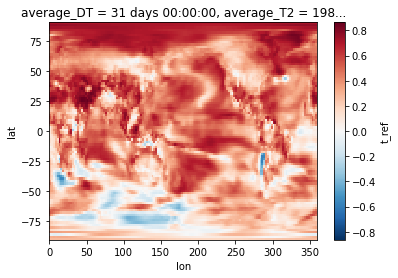

In [22]:
a["t_ref"].isel(lead=0).plot()

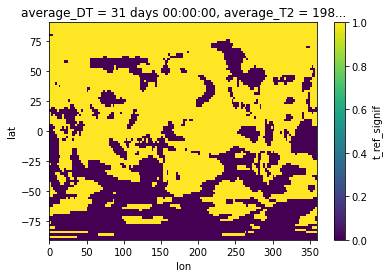

In [23]:
a["t_ref_signif"].isel(lead=0).plot()

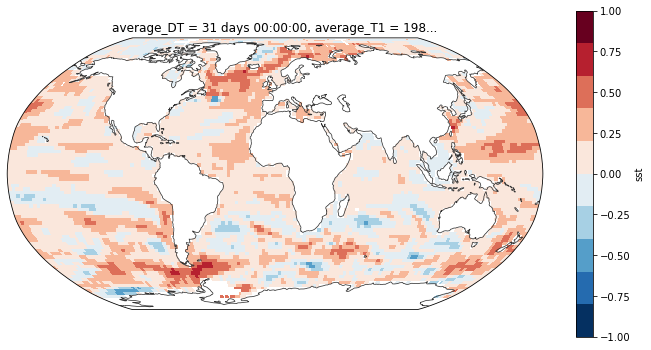

In [457]:
import matplotlib.cm as cm

fig = plt.figure(figsize=(12, 6), edgecolor="k")
ax = fig.add_subplot(111, projection=ccrs.Robinson(0))
cmap = cm.get_cmap("RdBu_r", 10)

p = (
    can_ri["sst"]
    .isel(lead=1)
    .plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap=cmap)
)

p.axes.coastlines(color=[0.2, 0.2, 0.2], linewidth=0.75)

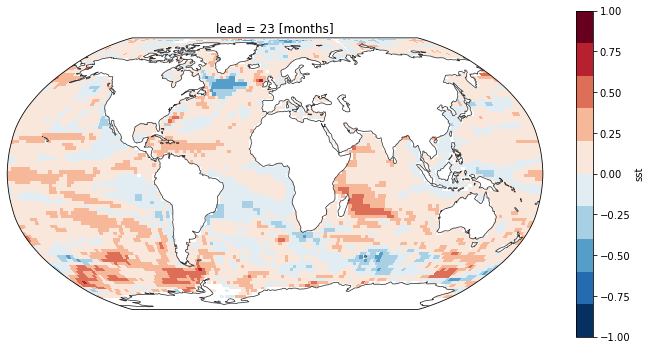

In [447]:
import matplotlib.cm as cm

fig = plt.figure(figsize=(12, 6), edgecolor="k")
ax = fig.add_subplot(111, projection=ccrs.Robinson(0))
cmap = cm.get_cmap("RdBu_r", 10)

p = (
    acc_init["sst"]
    .isel(lead=1)
    .plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap=cmap)
)

p.axes.coastlines(color=[0.2, 0.2, 0.2], linewidth=0.75)

# Is it faster to calculate the skill metric within `apply_ufunc`?

In [287]:
n_iterations = 1000

In [290]:
%%time

def mean_error_np(a, b):
    return np.mean(np.mean(a, axis=-1) - b, axis=-1)

bootstraps = [
    bootstrap_metric(
        hindcast_verif_times,
        references_verif_times,
        dim=["time", "member"],
        metric=mean_error_np,
    )
    for _ in range(n_iterations)
]
a = xr.concat(
        bootstraps, dim="iteration", coords="minimal", compat="override"
    )

with Client() as client:
    a = a.compute()

CPU times: user 1min 11s, sys: 9.62 s, total: 1min 20s
Wall time: 1min 19s


In [291]:
%%time

def mean_error(a, b):
    return (a.mean("member") - b).mean("time")

bootstraps = iterative_bootstrap(
    hindcast_verif_times,
    references_verif_times,
    dim=["time", "member"],
    n_iterations=n_iterations,
)

b = mean_error(*bootstraps)

with Client() as client:
    b = b.compute()

CPU times: user 1min 21s, sys: 10.5 s, total: 1min 31s
Wall time: 1min 29s


### Not by an amount that justifies the inconvenience...

# Old versions of bootstrapping functions

### Apply metric within ufunc

In [ ]:
from collections import OrderedDict


def _nested_random_indices(sizes):
    """
    Returns indices to randomly resample (with replacement) an array in a nested
    manner. I.e. randomly resample the first dimension, then for each randomly
    sampled element along that dimension, randomly resample the second dimension,
    then for each randomly sampled element along that dimension, randomly resample
    the third dimension etc.

    Parameters
    ----------
    sizes : OrderedDict
        Dictionary with the names and sizes of the dimensions to resample
    """

    shape = [s for s in sizes.values()]
    indices = OrderedDict()
    for ax, key in enumerate(sizes.keys()):
        indices[key] = np.random.randint(0, shape[ax], shape[: ax + 1])
    return indices


def _expand_nested_random_indices(indices):
    """
    Expand the dimensions of the nested input arrays so that they can be broadcast
    and return a tuple that can be directly indexed

    Parameters
    ----------
    indices : list of numpy arrays
        List of numpy arrays of sequentially increasing dimension as output by the
        function `nested_random_indices`
    """
    broadcast_ndim = indices[-1].ndim
    broadcast_indices = []
    for i, ind in enumerate(indices):
        broadcast_indices.append(
            np.expand_dims(ind, axis=list(range(i + 1, broadcast_ndim)))
        )
    return (..., *tuple(broadcast_indices))


def bootstrap_metric(*objects, dim, metric):
    """
    Bootstrap the provided array across the specified dimension(s) in a nested
    manner. I.e. bootstrap the first provided dimension, then for each
    bootstrapped sample along that dimenion, bootstrap the second provided
    dimension, then for each bootstrapped sample along that dimenion...

    Parameters
    ----------
    objects : iterable of Datasets
        The data to bootstrap. Multiple datasets can be passes to be
        bootstrapped in the same way. Where multiple datasets are passed,
        all datasets need not contain all bootstrapped dimensions. However,
        because of the bootstrapping is applied in a nested manner, the
        dimensions in all input objects must also be nested. E.g., for
        `dim=['d1','d2','d3']` an object with dimensions 'd1' and 'd2' is
        valid but an object with only dimension 'd2' is not.
    dim : str or iterable of str
        The dimension(s) to bootstrap in a nested manner.
    update_outer_dim_coords : boolean, optional
        If True, the index coordinates of the outer (first) dimension in
        dim and any non-index coordinates with this dimension are updated
        to reflect the bootstrap shuffling along that dimension. Otherwise,
        the data are shuffled, but the coordinates are left unchanged.
    """

    def _bootstrap(*arrays, indices, metric):
        """Bootstrap the array(s) using the provided indices"""
        bootstrapped = tuple([array[ind] for array, ind in zip(arrays, indices)])
        metric_bootstrapped = metric(*bootstrapped)
        return metric_bootstrapped

    if isinstance(dim, str):
        dim = [dim]

    # Get the sizes of the bootstrap dimensions
    sizes = None
    for obj in objects:
        try:
            sizes = OrderedDict({d: obj.sizes[d] for d in dim})
            break
        except KeyError:
            pass
    if sizes is None:
        raise ValueError("At least one input object must contain all dimensions in dim")

    # Generate the random indices first so that we can be sure that each
    # dask chunk uses the same indices. Note, I tried using random.seed()
    # to achieve this but it was flaky
    nested_indices = _nested_random_indices(sizes)  # Indices to resample all objects

    # Need to expand the indices for broadcasting for each object separately
    # as each object may have different dimensions
    indices = []
    input_core_dims = []
    for obj in objects:
        available_dims = [d for d in dim if d in obj.dims]
        indices_to_expand = [nested_indices[key] for key in available_dims]

        # Check that dimensions are nested
        ndims = [i.ndim for i in indices_to_expand]
        if ndims != list(range(1, len(ndims) + 1)):
            raise ValueError("The dimensions of all inputs must be nested")

        indices.append(_expand_nested_random_indices(indices_to_expand))
        input_core_dims.append(available_dims)

    return xr.apply_ufunc(
        _bootstrap,
        *objects,
        kwargs=dict(
            indices=indices,
            metric=metric,
        ),
        input_core_dims=input_core_dims,
        output_core_dims=[[]],
        keep_attrs=True,
        dask="parallelized",
        output_dtypes=[float],
    )

### Basic nested bootstrap

In [ ]:
from collections import OrderedDict


def _nested_random_indices(sizes):
    """
    Returns indices to randomly resample (with replacement) an array in a nested
    manner. I.e. randomly resample the first dimension, then for each randomly
    sampled element along that dimension, randomly resample the second dimension,
    then for each randomly sampled element along that dimension, randomly resample
    the third dimension etc.

    Parameters
    ----------
    sizes : OrderedDict
        Dictionary with the names and sizes of the dimensions to resample
    """

    shape = [s for s in sizes.values()]
    indices = OrderedDict()
    for ax, key in enumerate(sizes.keys()):
        indices[key] = np.random.randint(0, shape[ax], shape[: ax + 1])
    return indices


def _expand_nested_random_indices(indices):
    """
    Expand the dimensions of the nested input arrays so that they can be broadcast
    and return a tuple that can be directly indexed

    Parameters
    ----------
    indices : list of numpy arrays
        List of numpy arrays of sequentially increasing dimension as output by the
        function `nested_random_indices`
    """
    broadcast_ndim = indices[-1].ndim
    broadcast_indices = []
    for i, ind in enumerate(indices):
        broadcast_indices.append(
            np.expand_dims(ind, axis=list(range(i + 1, broadcast_ndim)))
        )
    return (..., *tuple(broadcast_indices))


def bootstrap(*objects, dim, update_outer_dim_coords=True):
    """
    Bootstrap the provided array across the specified dimension(s) in a nested
    manner. I.e. bootstrap the first provided dimension, then for each
    bootstrapped sample along that dimenion, bootstrap the second provided
    dimension, then for each bootstrapped sample along that dimenion...

    Parameters
    ----------
    objects : iterable of Datasets
        The data to bootstrap. Multiple datasets can be passes to be
        bootstrapped in the same way. Where multiple datasets are passed,
        all datasets need not contain all bootstrapped dimensions. However,
        because of the bootstrapping is applied in a nested manner, the
        dimensions in all input objects must also be nested. E.g., for
        `dim=['d1','d2','d3']` an object with dimensions 'd1' and 'd2' is
        valid but an object with only dimension 'd2' is not.
    dim : str or iterable of str
        The dimension(s) to bootstrap in a nested manner.
    update_outer_dim_coords : boolean, optional
        If True, the index coordinates of the outer (first) dimension in
        dim and any non-index coordinates with this dimension are updated
        to reflect the bootstrap shuffling along that dimension. Otherwise,
        the data are shuffled, but the coordinates are left unchanged.
    """

    def _bootstrap(*arrays, indices):
        """Bootstrap the array(s) using the provided indices"""
        bootstrapped = tuple([array[ind] for array, ind in zip(arrays, indices)])
        if len(bootstrapped) == 1:
            return bootstrapped[0]
        else:
            return bootstrapped

    if isinstance(dim, str):
        dim = [dim]

    # Get the sizes of the bootstrap dimensions
    sizes = None
    for obj in objects:
        try:
            sizes = OrderedDict({d: obj.sizes[d] for d in dim})
            break
        except KeyError:
            pass
    if sizes is None:
        raise ValueError("At least one input object must contain all dimensions in dim")

    # Generate the random indices first so that we can be sure that each
    # dask chunk uses the same indices. Note, I tried using random.seed()
    # to achieve this but it was flaky
    nested_indices = _nested_random_indices(sizes)  # Indices to resample all objects

    # Need to expand the indices for broadcasting for each object separately
    # as each object may have different dimensions
    indices = []
    input_core_dims = []
    for obj in objects:
        available_dims = [d for d in dim if d in obj.dims]
        indices_to_expand = [nested_indices[key] for key in available_dims]

        # Check that dimensions are nested
        ndims = [i.ndim for i in indices_to_expand]
        if ndims != list(range(1, len(ndims) + 1)):
            raise ValueError("The dimensions of all inputs must be nested")

        indices.append(_expand_nested_random_indices(indices_to_expand))
        input_core_dims.append(available_dims)

    results = xr.apply_ufunc(
        _bootstrap,
        *objects,
        kwargs=dict(
            indices=indices,
        ),
        input_core_dims=input_core_dims,
        output_core_dims=input_core_dims,
        keep_attrs=True,
        dask="parallelized",
        output_dtypes=[float] * len(input_core_dims),
        dask_gufunc_kwargs=dict(output_sizes=sizes),
    )

    def _update_outer_dim_coords(ds, outer_dim_indices):
        coords_to_update = [c for c in ds.coords if (dim[0] in ds[c].dims)]
        for c in coords_to_update:
            new_coord = ds[c].transpose(dim[0], ...)[outer_dim_indices]
            ds = ds.assign_coords({c: (new_coord.dims, new_coord.values)})
        return ds

    if update_outer_dim_coords:
        if len(objects) == 1:
            return _update_outer_dim_coords(results, nested_indices[dim[0]])
        else:
            return tuple(
                [
                    _update_outer_dim_coords(result, nested_indices[dim[0]])
                    for result in results
                ]
            )
    else:
        return results

In [ ]:
def iterative_bootstrap(*objects, dim, n_iterations):
    """
    Repeatedly bootstrap the provided array across the specified dimension(s)
    and stack the new arrays along a new "iteration" dimension. The
    boostrapping is done in a nested manner. I.e. bootstrap the first provided
    dimension, then for each bootstrapped sample along that dimenion, bootstrap
    the second provided dimension, then for each bootstrapped sample along that
    dimenion...

    Parameters
    ----------
    objects : iterable of Datasets
        The data to bootstrap. Multiple datasets can be passes to be
        bootstrapped in the same way. Where multiple datasets are passed,
        all datasets need not contain all bootstrapped dimensions. However,
        because of the bootstrapping is applied in a nested manner, the
        dimensions in all input objects must also be nested. E.g., for
        `dim=['d1','d2','d3']` an object with dimensions 'd1' and 'd2' is
        valid but an object with only dimension 'd2' is not.
    dim : str or iterable of str
        The dimension(s) to bootstrap in a nested manner.
    n_iterations : int
        The number of times to repeat the bootstrapping
    """
    bootstraps = [
        bootstrap(*objects, dim=dim, update_outer_dim_coords=False)
        for _ in range(n_iterations)
    ]
    if len(objects) == 1:
        return xr.concat(
            bootstraps, dim="iteration", coords="minimal", compat="override"
        )
    else:
        return tuple(
            [
                xr.concat(b, dim="iteration", coords="minimal", compat="override")
                for b in zip(*bootstraps)
            ]
        )

### Expand interations within ufunc
This works great for small numbers of iterations but kills the kernel for n O(1000)

In [39]:
from collections import OrderedDict


def _n_nested_random_indexes(sizes, iterations):
    """
    Returns indexes to randomly resample (with replacement) an array in a nested
    manner. I.e. randomly resample the first dimension, then for each randomly
    sampled element along that dimension, randomly resample the second dimension,
    then for each randomly sampled element along that dimension, randomly resample
    the third dimension etc.

    Parameters
    ----------
    sizes : OrderedDict
        Dictionary with the names and sizes of the dimensions to resample
    """

    shape = [s for s in sizes.values()]
    indexes = OrderedDict()
    for ax, key in enumerate(sizes.keys()):
        indexes[key] = np.random.randint(0, shape[ax], shape[: ax + 1] + [iterations])
    return indexes


def _expand_nested_random_indexes(indexes):
    """
    Expand the dimensions of the nested input arrays so that they can be broadcast
    and return a tuple that can be directly indexed

    Parameters
    ----------
    indexes : list of numpy arrays
        List of numpy arrays of sequentially increasing dimension as output by the
        function `nested_random_indexes`
    """
    broadcast_ndim = indexes[-1].ndim
    broadcast_indices = []
    for i, index in enumerate(indexes):
        expand_axes = list(range(i + 1, broadcast_ndim - 1))
        broadcast_indices.append(np.expand_dims(index, axis=expand_axes))
    return (..., *tuple(broadcast_indices))


def bootstrap_iterations(*objects, dim, update_outer_dim_coords=True):
    """
    Bootstrap the provided array across the specified dimension in a nested
    manner. I.e. bootstrap the first provided dimension, then for each
    bootstrapped sample along that dimenion, bootstrap the second provided
    dimension, then for each bootstrapped sample along that dimenion...

    Parameters
    ----------
    objects : iterable of Datasets
        The data to bootstrap. Multiple datasets can be passes to be
        bootstrapped in the same way. Where multiple datasets are passed,
        all datasets need not contain all bootstrapped dimensions. However,
        because of the bootstrapping is applied in a nested manner, the
        dimensions in all input objects must also be nested. E.g., for
        `dim=['d1','d2','d3']` an object with dimensions 'd1' and 'd2' is
        valid but an object with only dimension 'd2' is not.
    dim : str or iterable of str
        The dimension(s) to bootstrap in a nested manner.
    update_outer_dim_coords : boolean, optional
        If True, the index coordinates of the outer (first) dimension in
        dim and any non-index coordinates with this dimension are updated
        to reflect the bootstrap shuffling along that dimension. Otherwise,
        the data are shuffled, but the coordinates are left unchanged.
    """

    iterations = 1000

    def _bootstrap(*arrays, indexes):
        """Bootstrap the array(s) using the provided indexes"""
        bootstrapped = [array[ind] for array, ind in zip(arrays, indexes)]
        if len(bootstrapped) == 1:
            return bootstrapped[0]
        else:
            return tuple(bootstrapped)

    if isinstance(dim, str):
        dim = [dim]

    # Get the sizes of the bootstrap dimensions
    sizes = None
    for obj in objects:
        try:
            sizes = OrderedDict({d: obj.sizes[d] for d in dim})
            break
        except KeyError:
            pass
    if sizes is None:
        raise ValueError("At least one input object must contain all dimensions in dim")

    # Generate the random indices first so that we can be sure that each
    # dask chunk uses the same indices. Note, I tried using random.seed()
    # to achieve this but it was flaky
    nested_indexes = _n_nested_random_indexes(
        sizes, iterations
    )  # Indices to resample all objects

    # Need to expand the indexes for broadcasting for each object separately
    # as each object may have different dimensions
    indexes = []
    input_core_dims = []
    output_core_dims = []
    for obj in objects:
        available_dims = [d for d in dim if d in obj.dims]
        indexes_to_expand = [nested_indexes[key] for key in available_dims]

        # Check that dimensions are nested
        ndims = [i.ndim for i in indexes_to_expand]
        if ndims != list(range(2, len(ndims) + 2)):
            raise ValueError("The dimensions of all inputs must be nested")

        indexes.append(_expand_nested_random_indexes(indexes_to_expand))
        input_core_dims.append(available_dims)
        output_core_dims.append(available_dims + ["iteration"])

    results = xr.apply_ufunc(
        _bootstrap,
        *objects,
        kwargs=dict(
            indexes=indexes,
        ),
        input_core_dims=input_core_dims,
        output_core_dims=output_core_dims,
        dask="parallelized",
        dask_gufunc_kwargs=dict(output_sizes={"iteration": iterations}),
        output_dtypes=[np.float32] * len(input_core_dims),
    )

    return results


#     def update_outer_dim_coords(ds, outer_dim_indexes):
#         coords_to_update = [c for c in ds.coords if (dim[0] in ds[c].dims)]
#         for c in coords_to_update:
#             new_coord = ds[c].transpose(dim[0], ...)[outer_dim_indexes]
#             ds = ds.assign_coords({c: (new_coord.dims, new_coord.values)})
#         return ds

#     if update_outer_dim_coords:
#         if len(objects) == 1:
#             return update_outer_dim_coords(results, nested_indexes[dim[0]])
#         else:
#             return [
#                 update_outer_dim_coords(result, nested_indexes[dim[0]])
#                 for result in results
#             ]
#     else:
#         return results

In [ ]:
def test_nested_random_resample():
    """
    Tests the function nested_random_resample

    For each axis level of nested random sampling this checks that the elements
    outer to the randomly sample axis are the same for each random sample. This
    is only a check that the nesting hasn't not worked
    """

    import itertools

    # Generate some test data with data that makes it location clear
    shape = (6, 5, 4, 3, 2)
    axes = ["a", "b", "c", "d", "e"]
    n_axes = 2
    test = np.zeros(shape, dtype="<U16")
    for i in itertools.product(*[range(i) for i in shape]):
        test[i] = "".join([f"{axes[j]}{i[j]}" for j in range(len(i))])

    # Randomly resample the test data
    nested_indexes = _nested_random_indexes(dict(zip(axes, shape)))
    indexes = _expand_nested_random_indexes([nested_indexes[k] for k in axes])
    res = test[indexes]

    # Check that the nesting hasn't not worked
    for a in range(-n_axes, 0):
        # Look at a random location for the not sampled axes
        idx = [np.random.randint(0, i) for i in res.shape[:a]]
        idx.append(slice(None))

        for element_idx in itertools.product(*[range(i) for i in res.shape[a:][1:]]):
            to_check = res[tuple(idx + list(element_idx))]
            identical_elements = [s[: 2 * (res.ndim + a)] for s in to_check]
            assert len(set(identical_elements)) == 1